# compose visualisations of listener experience, Case Study 1


In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
import librosa
from IPython.display import Audio
import mir_eval.sonify
from pydub import AudioSegment
from matplotlib.transforms import ScaledTranslation


from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [2]:
%load_ext autoreload
%autoreload 1
%aimport rp2

In [3]:
 %reload_ext autoreload

In [4]:
def Part_maps(Entries):
    parts_on = {}
    cols = Entries.columns
    for c in cols:
        if Entries[c].isna().sum()>1:
            Entries.loc[Entries[c].notna(),['mm',c]]
            V = Entries.loc[Entries[c].notna(),['mm',c]]
            parts_on[c]=V.rename(columns = {c:'Playing'})
            D = pd.DataFrame(index = parts_on[c].index )
            for i in D.index:
                if parts_on[c].loc[i,'Playing'] == 1.0:
                    D[i] = D.index-i
            D[D>=0] = np.nan
            D['Pre'] = D.max(axis=1)
            D.loc[parts_on[c].loc[:,'Playing'] == 1.0,'Pre'] = 0.0
            parts_on[c]['Pre'] = D['Pre']
            parts_on[c]['Post'] = parts_on[c]['Pre'].diff()
            parts_on[c].loc[parts_on[c]['Post']<=0,'Post'] = 0.0
            parts_on[c][parts_on[c].isna()] = 0.0
    return parts_on
def resp_shade(ax,breaths,cat,colour):
    # shading plots
    resps_to_shade = breaths.query('Categories==@cat')
    for i,r in resps_to_shade.iterrows():
        ax.axvspan(r['In'],r['In']+r['Period_T'], facecolor=colour,alpha = 0.2)
    return

def resp_shaded(ax,breaths,cat,colour,alph = 0.4):
    # shading plots
    resps_to_shade = breaths.query('Categories==@cat')
    for i,r in resps_to_shade.iterrows():
        ax.axvspan(r['In'],r['In']+r['Insp_T'], facecolor=colour,alpha = alph )
        ax.axvspan(r['Ex'],r['Ex']+r['Exp_T'], facecolor=colour,alpha = alph - 0.2)
    return

def quickcarresp(Breaths):
    Insp_seq = Breaths.copy()#.query('In > @xlim[0] and In < @xlim[1]').copy().reset_index(drop=True)
    Insp_seq.loc[:,'dPT'] = np.log(Insp_seq['Period_T']/Insp_seq['Period_T'].shift(1)).abs()
    Insp_seq.loc[:,'dIT'] = np.log(Insp_seq['Insp_T']/Insp_seq['Insp_T'].shift(1)).abs()
    Insp_seq.loc[:,'dID'] = np.log(Insp_seq['IDepth']/Insp_seq['IDepth'].shift(1)).abs()
    Insp_seq.loc[:,'relD'] = np.log(Insp_seq['IDepth']/Insp_seq['IDepth'].rolling(5,center=True).median()).abs()
    
    depth_thresh = Insp_seq['IDepth'].median()*2
    low_D =  Insp_seq['IDepth'].quantile(0.25)
    mD =  Insp_seq['IDepth'].median()
    mT =  Insp_seq['Period_T'].median() 
    mIT =  Insp_seq['Insp_T'].median()
    
    Insp_seq['Categories']='Disturbed'

    V =  Insp_seq.query('Insp_T>0.5 and Period_T>2 and IDepth<3*@low_D and IE_Ratio>0.2 and dPT<0.5 and dID<0.5')
    Insp_seq.loc[V.index,'Categories']='Quiet'
    
    return Insp_seq

def minT(timestamps,timepoints):
    df = pd.DataFrame(index=timestamps,columns=['minT'],data = 0.0)
    for i in timestamps:
        df.loc[i,'minT']=(timepoints-i).abs().min()
    return df

## SSOdata

In [7]:
pwd

'/Users/finn/Desktop/Current_Projects/BiC/Audience_Interviewed/ExploratoryListening_repo'

In [8]:
# audio file locations in
data_loc = './data/'
mydpi = 196

In [9]:
Pentries = pd.read_csv(data_loc +'Performance_data/PlayTimings_Lydo2024 - C5_Saev_themes.csv') 
concert = 'C5'
buff = 10
s_time = -buff #C_times.loc[0,concert]
e_time = Pentries[concert].iloc[-1]+buff
dur = (e_time - s_time)-2*buff
ev = {}
ev['Event'] = 'Kjempeviseslåtten'
ev['Related'] = 'Saev'

In [10]:
piece = ev['Related']
Pstructures = Pentries.loc[Pentries['Structure'].notna(),:]
Prehearse = Pentries.loc[Pentries['RehNo'].notna(),:]
annotations = pd.read_csv(data_loc + 'Annotations/Case1_Resp_Notes.csv')
Prehearse

,C5,mm,mm_original,RehNo,Structure,Theme,Conductor,Flute_1,Flute_2,Oboe_1,...,Perc_GC,Harp,Vn_solo,Violin_1,Violin_2,Va_solo,Viola,Vc_Solo,Cello,Contrabass
2,4.778667,1.0,51.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,25.032667,9.0,59.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
14,44.053333,17.0,67.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,62.541333,25.0,75.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,81.200667,33.0,83.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,99.400667,41.0,91.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN
40,117.032667,49.0,99.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
43,133.805333,57.0,107.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
51,150.752000,65.0,115.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,167.234667,73.0,123.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Sensor measurements
df_feats= pd.read_csv(data_loc + 'Physiological_data/Case1_Saev_Feats.csv',index_col=0)
Breaths = rp2.breath_cycles(rp2.EQ_Inspiration_Extract(df_feats.loc[:,'Resp_wave']),df_feats.loc[:,'Resp_wave'])
Insp_seq = quickcarresp(Breaths)
R = (df_feats.loc[:,'Resp_wave']-df_feats.loc[:,'Resp_wave'].median())/Insp_seq['IDepth'].median()
df_feats.loc[:,'Resp_wave'] = R

In [12]:
C_df = pd.read_csv('./outfiles/C5_Saev_10_cqt.csv',index_col = 0)
C_df.iloc[:5,:]

,83,82,81,80,79,78,77,76,75,74,...,9,8,7,6,5,4,3,2,1,0
-10.000,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0
-9.977,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0
-9.954,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0
-9.930,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0
-9.907,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0


In [13]:
# labels and categories
palettes = ['c','m','g','r','b','k'] # instrument playing time shading
respcats = ['Disturbed','Quiet']
palette={'Disturbed':'c','Quiet':'lightblue'} # respiration categories
pitchticks = np.arange(7,84,12)
pitchticklabels=['C1','C2','C3','C4','C5','C6','C7']

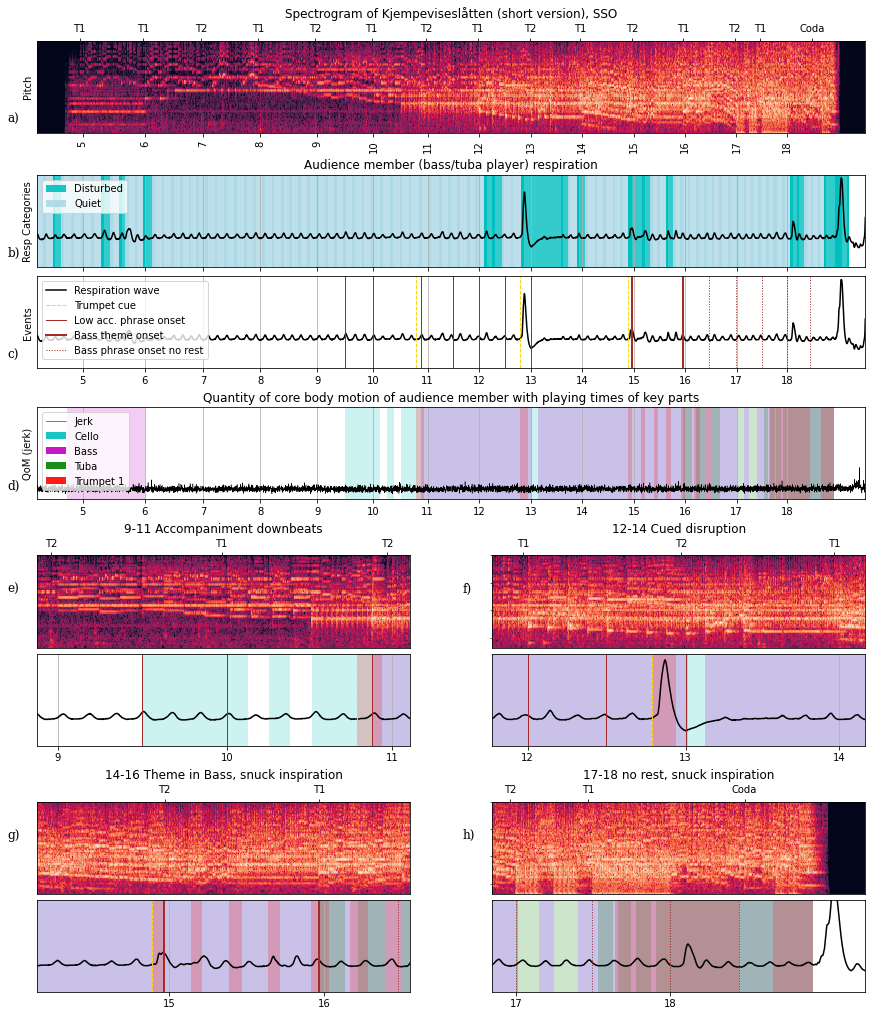

In [14]:
fig3 = plt.figure(constrained_layout=True,figsize=(12,14))
gs = fig3.add_gridspec(8, 2)
axes={}
axes[0] = fig3.add_subplot(gs[0, :])
axes[1] = fig3.add_subplot(gs[1, :])
axes[2] = fig3.add_subplot(gs[2, :])
axes[3] = fig3.add_subplot(gs[3, :])
axes[4] = fig3.add_subplot(gs[4,0])
axes[5] = fig3.add_subplot(gs[5,0])
axes[6] = fig3.add_subplot(gs[4,1])
axes[7] = fig3.add_subplot(gs[5,1])
axes[8] = fig3.add_subplot(gs[6,0])
axes[9] = fig3.add_subplot(gs[7,0])
axes[10] = fig3.add_subplot(gs[6,1])
axes[11] = fig3.add_subplot(gs[7,1])

buff = 10
s_time = -buff
e_time = dur+buff
ax=axes[0]
ax.set(title='Spectrogram of Kjempeviseslåtten (short version), SSO') # with Rehearsal numbers and Structure
chart = sns.heatmap(data=C_df.loc[s_time:e_time].transpose(),cmap="rocket",ax=ax,cbar = False)# ,'label': 'Expiration | Inspiration', ,cbar_kws={'ticks':[],'use_gridspec':False,'location':"top"}
frameN = len(C_df.loc[s_time:e_time,:])
t_C1 = list(C_df.loc[s_time:e_time,:].index)
t_Alt =  np.linspace(0, frameN - 1,frameN,dtype='int')
f = interpolate.interp1d(t_C1,t_Alt,fill_value='extrapolate',kind='linear')
ax.set(xticks = f(Prehearse.loc[:,'C5']),xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')),yticks=[])
ax.set_ylabel('Pitch')  
ax1 = ax.twiny()
ax1.set(xticks = Pstructures.loc[:,'C5'],xticklabels=Pstructures.loc[:,'Structure'])
ax1.set_xlim([s_time,e_time])

resprange = [-7,15]
ax=axes[1]
ax.set(title = 'Audience member (bass/tuba player) respiration',ylabel='Resp Categories')
df_feats.loc[:,'Resp_wave'].plot(c='k',linestyle='-',label="",ax = ax)
for cat in respcats: 
    ax.axvspan(-20,-15, facecolor=palette[cat],alpha = 0.9,label=cat)
ax.legend(loc='upper left') 
for cat in respcats:
    resp_shaded(ax,Insp_seq,cat,palette[cat],1.0)
ax.set(ylim=resprange,xlim=[s_time,e_time],yticks=[],xlabel='')
ax.set(xticks = Prehearse.loc[:,'C5'],xticklabels=[])
ax.grid()

ax=axes[2]
df_feats.loc[:,'Resp_wave'].plot(c='k',linestyle='-',label="Respiration wave",ax = ax)
ax.set(ylim=resprange,xlim=[s_time,e_time],yticks=[],xlabel='')
ax.set(xticks = Prehearse.loc[:,'C5'],xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')))
ax.grid()
ax.set(title = '',ylabel='Events')

yrange = resprange
ax.plot([-20, -20],yrange,linestyle = '--',linewidth=1,color='gold',label = "Trumpet cue")
ax.plot([-20, -20],yrange,linestyle = '-',linewidth=1,color='brown',label = "Low acc. phrase onset") 
ax.plot([-20, -20],yrange,linestyle = '-',linewidth=2,color='brown',label = "Bass theme onset") 
ax.plot([-20, -20],yrange,linestyle = ':',linewidth=1,color='brown',label = "Bass phrase onset no rest") 
ax.legend(loc='upper left')

tcue_list = [8,13,18]
lowpart_downbeatACCphrase = [6,7,9,10,11,12,14] #6,7 # ,14,15,16 20,25
entry_melody = [19,21] 
norest_list = [22,23,26,25,26,28]

for tcue in annotations.loc[tcue_list,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = '--',linewidth=1,color='gold')   
for tcue in annotations.loc[lowpart_downbeatACCphrase ,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = '-',linewidth=1,color='brown')
for tcue in annotations.loc[entry_melody,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = '-',linewidth=2,color='brown')
for tcue in annotations.loc[norest_list,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = ':',linewidth=1,color='brown')


ax=axes[3]
ax.set(title = 'Quantity of core body motion of audience member with playing times of key parts',ylabel = 'QoM (jerk)')
df_feats.loc[:,'Jerk'].plot(c='k',linewidth=0.5,ax = ax)
ax.set(ylim=[0,100],xlim=[s_time,e_time],yticks=[],xlabel='')
ax.set(xticks = Prehearse.loc[:,'C5'],xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')))
ax.grid()

palettes = ['c','m','g','r','b','k']
Pentries['Time_s'] = Pentries[concert]
Pentries = Pentries.set_index('Time_s',drop = True)
Part_entries = Part_maps(Pentries) 
parts= [ 'Vc_Solo','Contrabass','Tuba','Trumpet_1'] 
parts_labels = {'Vc_Solo':'Cello','Contrabass':'Bass','Tuba':'Tuba','Trumpet_1':'Trumpet 1'}
k = 0
for part in parts: #'Vocal?',
    ax.axvspan(-20,-15, facecolor=palettes[k],alpha = 0.9,label=parts_labels[part])
    k+=1
ax.legend(loc='upper left')

k = 0
for part in parts:
    Entries = Part_entries[part].copy() 
    es = Entries.index[Entries['Playing']==1.0]
    ee = Entries.index[Entries['Playing']==0.0]
    if len(ee)>len(es): ee = ee[1:]  
    for i in range(len(es)):
        ax.axvspan(es[i],ee[i], facecolor=palettes[k],alpha = 0.2)
    k+=1
    
    
resprange = [-5,12]

intervals={
"9-11 Accompaniment downbeats":[79,119],
"12-14 Cued disruption":[130,170],
"14-16 Theme in Bass, snuck inspiration":[170,210],
"17-18 no rest, snuck inspiration":[215,255] }

excerpts_Label=list(intervals.keys())
for i in range(4):
    exc = excerpts_Label[i]
    [s_time,e_time] = intervals[exc]
    
    ax = axes[(i*2)+4]
    chart = sns.heatmap(data=C_df.loc[s_time:e_time].transpose(),cmap="rocket",ax=ax,cbar = False)# ,'label': 'Expiration | Inspiration', ,cbar_kws={'ticks':[],'use_gridspec':False,'location':"top"}
    ax.set(xticks=[],xticklabels=[],yticks=[],yticklabels=[]) #,ylabel='Audio'
    ax.set_title(exc)
    ax1 = ax.twiny()
    ax1.set(xticks = Pstructures.loc[:,'C5'],xticklabels=Pstructures.loc[:,'Structure'])
    ax1.set_xlim([s_time,e_time])
    
    ax = axes[(i*2)+5]

    df_feats.loc[:,'Resp_wave'].plot(c='k',ax = ax)
    yrange = resprange
    for tcue in annotations.loc[tcue_list,'TIME']:
        ax.plot([tcue, tcue],yrange,linestyle = '--',linewidth=1,color='gold')   
    for tcue in annotations.loc[lowpart_downbeatACCphrase ,'TIME']:
        ax.plot([tcue, tcue],yrange,linestyle = '-',linewidth=1,color='brown')
    for tcue in annotations.loc[entry_melody,'TIME']:
        ax.plot([tcue, tcue],yrange,linestyle = '-',linewidth=2,color='brown')
    for tcue in annotations.loc[norest_list,'TIME']:
        ax.plot([tcue, tcue],yrange,linestyle = ':',linewidth=1,color='brown')
  
    ax.set(xticks = Prehearse.loc[:,'C5'],xticklabels=Prehearse.loc[:,'RehNo'].astype('int'),yticks=[],yticklabels=[]) #,ylabel='Resp'
    ax.set(xlim =[s_time,e_time],xlabel='',ylim=resprange)
    ax.grid()
    
    k = 0
    for part in parts:
        Entries = Part_entries[part].copy() 
        es = Entries.index[Entries['Playing']==1.0]
        ee = Entries.index[Entries['Playing']==0.0]
        if len(ee)>len(es): ee = ee[1:]  
        for i in range(len(es)):
            ax.axvspan(es[i],ee[i], facecolor=palettes[k],alpha = 0.2)
        k+=1

ax_labels = ['a)','b)','c)','d)','e)','','f)','','g)','','h)','','i)','j)','k)','l)','m)','n)']
for i in range(len(axes)):
    ax = axes[i]
    label = ax_labels[i]
    if i<4:
        ax.text(0.0, 1.0, label, transform=(
                ax.transAxes + ScaledTranslation(-30/72, -85/72, fig3.dpi_scale_trans)),
            fontsize='large', va='bottom', fontfamily='serif')
    if i>=4:
        ax.text(0.0, 1.0, label, transform=(
                ax.transAxes + ScaledTranslation(-30/72, -40/72, fig3.dpi_scale_trans)),
            fontsize='large', va='bottom', fontfamily='serif')
        
outplots = './plots/'
figname = '_'.join(['Compound_Excerpts_CaseStudy1.png'])
plt.savefig(outplots+figname,bbox_inches = 'tight',dpi = 196)
plt.show()

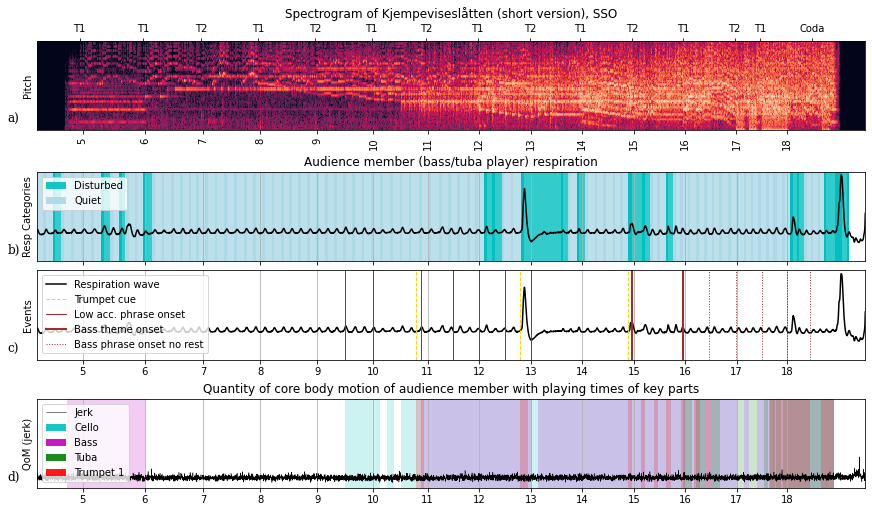

In [15]:
fig3 = plt.figure(constrained_layout=True,figsize=(12,7))
gs = fig3.add_gridspec(4, 1)
axes={}
axes[0] = fig3.add_subplot(gs[0, :])
axes[1] = fig3.add_subplot(gs[1, :])
axes[2] = fig3.add_subplot(gs[2, :])
axes[3] = fig3.add_subplot(gs[3, :])


buff = 10
s_time = -buff
e_time = dur+buff
ax=axes[0]
ax.set(title='Spectrogram of Kjempeviseslåtten (short version), SSO') # with Rehearsal numbers and Structure
chart = sns.heatmap(data=C_df.loc[s_time:e_time].transpose(),cmap="rocket",ax=ax,cbar = False)# ,'label': 'Expiration | Inspiration', ,cbar_kws={'ticks':[],'use_gridspec':False,'location':"top"}
frameN = len(C_df.loc[s_time:e_time,:])
t_C1 = list(C_df.loc[s_time:e_time,:].index)
t_Alt =  np.linspace(0, frameN - 1,frameN,dtype='int')
f = interpolate.interp1d(t_C1,t_Alt,fill_value='extrapolate',kind='linear')
ax.set(xticks = f(Prehearse.loc[:,'C5']),xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')),yticks=[])
ax.set_ylabel('Pitch')  
ax1 = ax.twiny()
ax1.set(xticks = Pstructures.loc[:,'C5'],xticklabels=Pstructures.loc[:,'Structure'])
ax1.set_xlim([s_time,e_time])

resprange = [-7,15]
ax=axes[1]
ax.set(title = 'Audience member (bass/tuba player) respiration',ylabel='Resp Categories')
df_feats.loc[:,'Resp_wave'].plot(c='k',linestyle='-',label="",ax = ax)
for cat in respcats: 
    ax.axvspan(-20,-15, facecolor=palette[cat],alpha = 0.9,label=cat)
ax.legend(loc='upper left') 
for cat in respcats:
    resp_shaded(ax,Insp_seq,cat,palette[cat],1.0)
ax.set(ylim=resprange,xlim=[s_time,e_time],yticks=[],xlabel='')
ax.set(xticks = Prehearse.loc[:,'C5'],xticklabels=[])
ax.grid()

ax=axes[2]
df_feats.loc[:,'Resp_wave'].plot(c='k',linestyle='-',label="Respiration wave",ax = ax)
ax.set(ylim=resprange,xlim=[s_time,e_time],yticks=[],xlabel='')
ax.set(xticks = Prehearse.loc[:,'C5'],xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')))
ax.grid()
ax.set(title = '',ylabel='Events')

yrange = resprange
ax.plot([-20, -20],yrange,linestyle = '--',linewidth=1,color='gold',label = "Trumpet cue")
ax.plot([-20, -20],yrange,linestyle = '-',linewidth=1,color='brown',label = "Low acc. phrase onset") 
ax.plot([-20, -20],yrange,linestyle = '-',linewidth=2,color='brown',label = "Bass theme onset") 
ax.plot([-20, -20],yrange,linestyle = ':',linewidth=1,color='brown',label = "Bass phrase onset no rest") 
ax.legend(loc='upper left')

tcue_list = [8,13,18]
lowpart_downbeatACCphrase = [6,7,9,10,11,12,14] #6,7 # ,14,15,16 20,25
entry_melody = [19,21] 
norest_list = [22,23,26,25,26,28]

for tcue in annotations.loc[tcue_list,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = '--',linewidth=1,color='gold')   
for tcue in annotations.loc[lowpart_downbeatACCphrase ,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = '-',linewidth=1,color='brown')
for tcue in annotations.loc[entry_melody,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = '-',linewidth=2,color='brown')
for tcue in annotations.loc[norest_list,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = ':',linewidth=1,color='brown')


ax=axes[3]
ax.set(title = 'Quantity of core body motion of audience member with playing times of key parts',ylabel = 'QoM (jerk)')
df_feats.loc[:,'Jerk'].plot(c='k',linewidth=0.5,ax = ax)
ax.set(ylim=[0,100],xlim=[s_time,e_time],yticks=[],xlabel='')
ax.set(xticks = Prehearse.loc[:,'C5'],xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')))
ax.grid()

palettes = ['c','m','g','r','b','k']
Pentries['Time_s'] = Pentries[concert]
Pentries = Pentries.set_index('Time_s',drop = True)
Part_entries = Part_maps(Pentries) 
parts= [ 'Vc_Solo','Contrabass','Tuba','Trumpet_1'] 
parts_labels = {'Vc_Solo':'Cello','Contrabass':'Bass','Tuba':'Tuba','Trumpet_1':'Trumpet 1'}
k = 0
for part in parts: #'Vocal?',
    ax.axvspan(-20,-15, facecolor=palettes[k],alpha = 0.9,label=parts_labels[part])
    k+=1
ax.legend(loc='upper left')

k = 0
for part in parts:
    Entries = Part_entries[part].copy() 
    es = Entries.index[Entries['Playing']==1.0]
    ee = Entries.index[Entries['Playing']==0.0]
    if len(ee)>len(es): ee = ee[1:]  
    for i in range(len(es)):
        ax.axvspan(es[i],ee[i], facecolor=palettes[k],alpha = 0.2)
    k+=1


ax_labels = ['a)','b)','c)','d)']
for i in range(len(axes)):
    ax = axes[i]
    label = ax_labels[i]
    if i<4:
        ax.text(0.0, 1.0, label, transform=(
                ax.transAxes + ScaledTranslation(-30/72, -85/72, fig3.dpi_scale_trans)),
            fontsize='large', va='bottom', fontfamily='serif')
    if i>=4:
        ax.text(0.0, 1.0, label, transform=(
                ax.transAxes + ScaledTranslation(-30/72, -40/72, fig3.dpi_scale_trans)),
            fontsize='large', va='bottom', fontfamily='serif')
        
outplots = './plots/'
figname = '_'.join(['Compound_Excerpts_CaseStudy1_part1.png'])
plt.savefig(outplots+figname,bbox_inches = 'tight',dpi = 196)
plt.show()

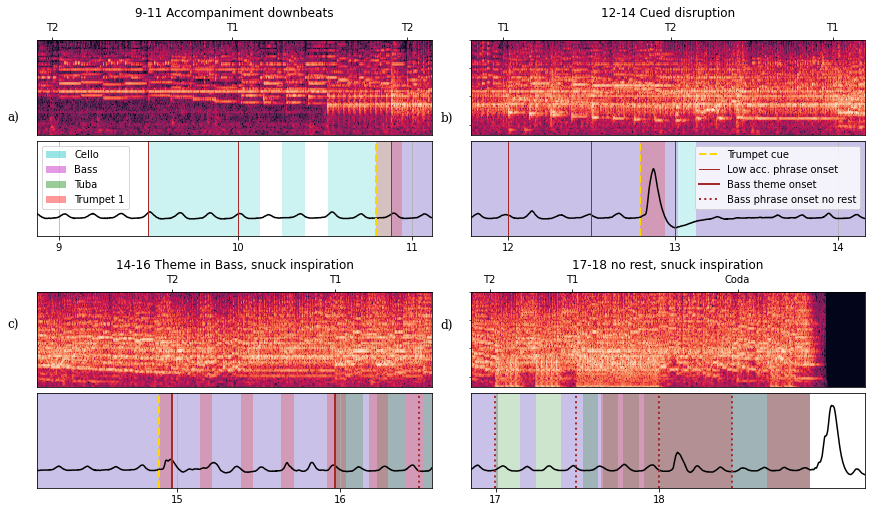

In [64]:
fig3 = plt.figure(constrained_layout=True,figsize=(12,7))
gs = fig3.add_gridspec(4, 2)
axes={}
axes[0] = fig3.add_subplot(gs[0,0])
axes[1] = fig3.add_subplot(gs[1,0])
axes[2] = fig3.add_subplot(gs[0,1])
axes[3] = fig3.add_subplot(gs[1,1])
axes[4] = fig3.add_subplot(gs[2,0])
axes[5] = fig3.add_subplot(gs[3,0])
axes[6] = fig3.add_subplot(gs[2,1])
axes[7] = fig3.add_subplot(gs[3,1])
    
    
resprange = [-4,17]

intervals={
"9-11 Accompaniment downbeats":[79,119],
"12-14 Cued disruption":[130,170],
"14-16 Theme in Bass, snuck inspiration":[170,210],
"17-18 no rest, snuck inspiration":[215,255] }

excerpts_Label=list(intervals.keys())
for i in range(4):
    exc = excerpts_Label[i]
    [s_time,e_time] = intervals[exc]
    
    ax = axes[(i*2)]
    chart = sns.heatmap(data=C_df.loc[s_time:e_time].transpose(),cmap="rocket",ax=ax,cbar = False)# ,'label': 'Expiration | Inspiration', ,cbar_kws={'ticks':[],'use_gridspec':False,'location':"top"}
    ax.set(xticks=[],xticklabels=[],yticks=[],yticklabels=[]) #,ylabel='Audio'
    ax.set_title(exc)
    ax1 = ax.twiny()
    ax1.set(xticks = Pstructures.loc[:,'C5'],xticklabels=Pstructures.loc[:,'Structure'])
    ax1.set_xlim([s_time,e_time])
    
    ax = axes[(i*2)+1]

    if i == 0: # add part legend
        k = 0
        for part in parts: #'Vocal?',
            ax.axvspan(-20,-15, facecolor=palettes[k],alpha = 0.4,label=parts_labels[part])
            k+=1
        ax.legend(loc='upper left')
        
    if i == 1: # add annotation legend
        k = 0
        yrange = resprange
        ax.plot([-20, -20],yrange,linestyle = '--',linewidth=2,color='gold',label = "Trumpet cue")
        ax.plot([-20, -20],yrange,linestyle = '-',linewidth=1,color='brown',label = "Low acc. phrase onset") 
        ax.plot([-20, -20],yrange,linestyle = '-',linewidth=2,color='brown',label = "Bass theme onset ") 
        ax.plot([-20, -20],yrange,linestyle = ':',linewidth=2,color='brown',label = "Bass phrase onset no rest") 
        ax.legend(loc='upper right')
#     else:     df_feats.loc[:,'Resp_wave'].plot(c='k',ax = ax)

    df_feats.loc[:,'Resp_wave'].plot(c='k',ax = ax)

    yrange = resprange
    for tcue in annotations.loc[tcue_list,'TIME']:
        ax.plot([tcue, tcue],yrange,linestyle = '--',linewidth=2,color='gold')   
    for tcue in annotations.loc[lowpart_downbeatACCphrase ,'TIME']:
        ax.plot([tcue, tcue],yrange,linestyle = '-',linewidth=1,color='brown')
    for tcue in annotations.loc[entry_melody,'TIME']:
        ax.plot([tcue, tcue],yrange,linestyle = '-',linewidth=2,color='brown')
    for tcue in annotations.loc[norest_list,'TIME']:
        ax.plot([tcue, tcue],yrange,linestyle = ':',linewidth=2,color='brown')
  
    ax.set(xticks = Prehearse.loc[:,'C5'],xticklabels=Prehearse.loc[:,'RehNo'].astype('int'),yticks=[],yticklabels=[]) #,ylabel='Resp'
    ax.set(xlim =[s_time,e_time],xlabel='',ylim=resprange)
    ax.grid()
    
    k = 0
    for part in parts:
        Entries = Part_entries[part].copy() 
        es = Entries.index[Entries['Playing']==1.0]
        ee = Entries.index[Entries['Playing']==0.0]
        if len(ee)>len(es): ee = ee[1:]  
        for i in range(len(es)):
            ax.axvspan(es[i],ee[i], facecolor=palettes[k],alpha = 0.2)
        k+=1

ax_labels = ['a)','','b)','','c)','','d)','']
for i in range(len(axes)):
    ax = axes[i]
    label = ax_labels[i]
    if i<4:
        ax.text(0.0, 1.0, label, transform=(
                ax.transAxes + ScaledTranslation(-30/72, -85/72, fig3.dpi_scale_trans)),
            fontsize='large', va='bottom', fontfamily='serif')
    if i>=4:
        ax.text(0.0, 1.0, label, transform=(
                ax.transAxes + ScaledTranslation(-30/72, -40/72, fig3.dpi_scale_trans)),
            fontsize='large', va='bottom', fontfamily='serif')
        
outplots = './plots/'
figname = '_'.join(['Compound_Excerpts_CaseStudy1_part2.png'])
plt.savefig(outplots+figname,bbox_inches = 'tight',dpi = 196)
plt.show()

## Phase Categories across audience members to SSO performances of Kjempe....

Note this is demonstrating the processing of respiration recordings not published as part of this data set. 

In [55]:
df_alts = pd.read_csv(data_loc + 'Physiological_data/Case1_Saev_OtherResp.csv',index_col=0)
ratios = pd.Series()
for partID in df_alts.columns:
    # normalise each respiration wave
    resp_sig = df_alts[partID]
    Breaths = rp2.breath_cycles(rp2.EQ_Inspiration_Extract(resp_sig),resp_sig)
    Insp_seq = quickcarresp(Breaths)
    Qratio = Insp_seq.query('Categories=="Quiet"').loc[:,'Period_T'].sum()/Insp_seq.loc[:,'Period_T'].sum()
    ratios[partID]=Qratio
    
Breaths = rp2.breath_cycles(rp2.EQ_Inspiration_Extract(df_feats.loc[:,'Resp_wave']),df_feats.loc[:,'Resp_wave'])
Insp_seq = quickcarresp(Breaths)
Qratio = Insp_seq.query('Categories=="Quiet"').loc[:,'Period_T'].sum()/Insp_seq.loc[:,'Period_T'].sum()
ratios['AU801']=Qratio
ratios

AU811    0.718822
AU808    0.755884
AU802    0.680956
AU807    0.052120
AU804    0.552495
AU809    0.738211
AU810    0.894788
AU806    0.537185
AU803    0.613308
AU819    0.597028
AU814    0.729231
AU816    0.091152
AU813    0.446716
AU818    0.809870
AU815    0.760425
AU812    0.773572
AU817    0.702212
AU820    0.552481
AU801    0.780314
dtype: float64

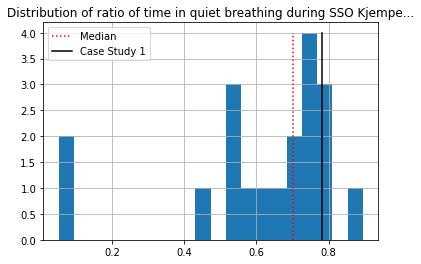

0.7022120467071181

In [56]:
ratios.hist(bins=20)
plt.plot([ratios.median(),ratios.median()],[0,4],'r:',label='Median')
plt.plot([ratios['AU801'],ratios['AU801']],[0,4],'k',label='Case Study 1')
plt.title('Distribution of ratio of time in quiet breathing during SSO Kjempe...')
plt.legend()
plt.show()
ratios.median()

# Expirations alignment with annotated moments

Evaluation of likelyhood of phase alignment (expirations) with identified moments

In [21]:
# Sensor measurements
df_feats= pd.read_csv(data_loc + 'Physiological_data/Case1_Saev_Feats.csv',index_col=0)
Breaths = rp2.breath_cycles(rp2.EQ_Inspiration_Extract(df_feats.loc[:,'Resp_wave']),df_feats.loc[:,'Resp_wave'])
Insp_seq = quickcarresp(Breaths)
R = (df_feats.loc[:,'Resp_wave']-df_feats.loc[:,'Resp_wave'].median())/Insp_seq['IDepth'].median()
df_feats.loc[:,'Resp_wave'] = R

sig = 'IminT'
df_feats[sig]= minT(df_feats.index,Breaths['In'])['minT'].values
sig = 'EminT'
df_feats[sig]= minT(df_feats.index,Breaths['Ex'])['minT'].values


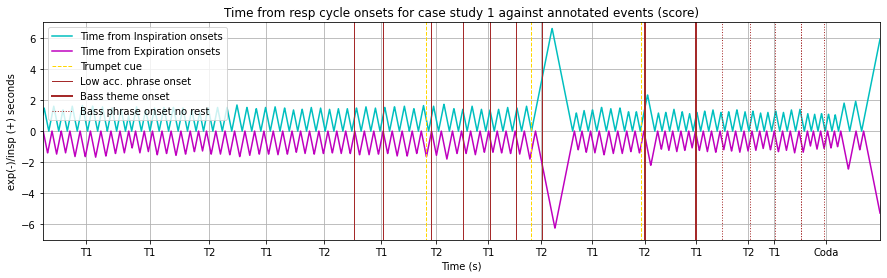

In [22]:
buff = 10
s_time = -buff
e_time = dur+buff

ax = df_feats['IminT'].plot(figsize=[15,4],color='c',label='Time from Inspiration onsets')
(-df_feats['EminT']).plot(ax=ax,color='m',label='Time from Expiration onsets')
ax.set_title('Time from resp cycle onsets for case study 1 against annotated events (score)')
ax.set(xticks = Pstructures.loc[:,'C5'],xticklabels=Pstructures.loc[:,'Structure'])

yrange = [-10,10]
tcue_list = [8,13,18]
lowpart_downbeatACCphrase = [6,7,9,10,11,12,14]
entry_melody = [19,21] 
norest_list = [22,23,26,25,26,28]

# just for legend
ax.plot([-20, -20],yrange,linestyle = '--',linewidth=1,color='gold',label = "Trumpet cue")
ax.plot([-20, -20],yrange,linestyle = '-',linewidth=1,color='brown',label = "Low acc. phrase onset") 
ax.plot([-20, -20],yrange,linestyle = '-',linewidth=2,color='brown',label = "Bass theme onset") 
ax.plot([-20, -20],yrange,linestyle = ':',linewidth=1,color='brown',label = "Bass phrase onset no rest") 
ax.legend(loc='upper left')

for tcue in annotations.loc[tcue_list,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = '--',linewidth=1,color='gold',)   
for tcue in annotations.loc[lowpart_downbeatACCphrase ,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = '-',linewidth=1,color='brown')
for tcue in annotations.loc[entry_melody,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = '-',linewidth=2,color='brown')
for tcue in annotations.loc[norest_list,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = ':',linewidth=1,color='brown')

ax.set(xlim=[s_time,e_time],ylim=[-7,7],xlabel='Time (s)',ylabel='exp(-)/insp (+) seconds') 
ax.grid()
plt.show()


Low acc. phrase onsets and bass theme onsets intersect with time from expiration onset functions close to zero. The bass phrase onsets with no rest mostly intersect offset. Note also the inspirations around the time of trumpet cues for entries. 

Some coincidences are not a strong indication of influence alone. We can test the quality of alignment by comparing the distances (time) to expiration onsets for a similar distribution of entry points starting from other times.

In [23]:
entry_list = lowpart_downbeatACCphrase + entry_melody
print(len(entry_list))
entry_list

9


[6, 7, 9, 10, 11, 12, 14, 19, 21]

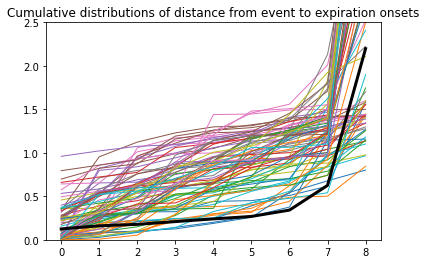

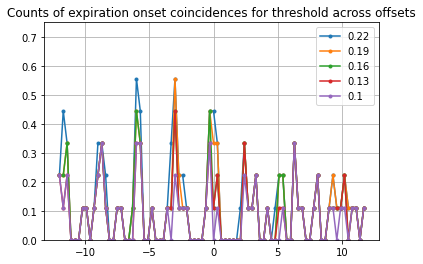

In [59]:
# not sure exactly how close expirations need to be to thsee moments to count as "aligned", so document a range
threshrange = np.round(np.arange(0.1,0.24,0.03),2)

# sample 
f = interpolate.interp1d(df_feats.index, df_feats['EminT'],fill_value='extrapolate')

# sample distrubution of expiration onsets within threshold to event list when assess at different offsets

prox = pd.DataFrame(index = np.arange(-12,12,0.3),columns=threshrange[::-1])
for delta in prox.index:
    C = f(annotations.loc[entry_list,'TIME']+delta)
    C = pd.Series(C).sort_values().reset_index(drop=True)
    C.plot(linewidth=1)
    for thresh in threshrange:
        prox.loc[delta,thresh]=(C<thresh).sum()/len(C)
C = f(annotations.loc[entry_list,'TIME'])
C = pd.Series(C).sort_values().reset_index(drop=True)
C.plot(c='k',linewidth=3,label='Original')
plt.ylim([0,2.5])
plt.title('Cumulative distributions of distance from event to expiration onsets')
plt.show()

prox.plot(kind='line',marker='.')
plt.ylim([0,0.75])
plt.title('Counts of expiration onset coincidences for threshold across offsets')
plt.grid()
plt.show()

This comparison shows that the original alignment is stands out as relatively high, the black line of the original cumulative distribution is at the low end of the alternatives. However the quiet breathing cycles supports the possibility of incidental alignments. Here timing is a suggestion of influence but other arguments (respiratory shape etc) provide necessary additional support for the embodied influences.

### check out alignments with other audience member resipiration sequences

In [47]:
df_alts = pd.read_csv(data_loc + 'Physiological_data/Case1_Saev_OtherResp.csv',index_col=0)
df_IminT = df_alts.copy()
df_EminT = df_alts.copy()
for partID in df_alts.columns:
    # normalise each respiration wave
    resp_sig = df_alts[partID]
    Breaths = rp2.breath_cycles(rp2.EQ_Inspiration_Extract(resp_sig),resp_sig)
    Insp_seq = quickcarresp(Breaths)
    R = (resp_sig-resp_sig.median())/Insp_seq['IDepth'].median()
    df_alts[partID] = R

    # save phase distances series for each 
    df_IminT[partID]= minT(R.index,Breaths['In'])['minT'].values
    df_EminT[partID]= minT(R.index,Breaths['Ex'])['minT'].values

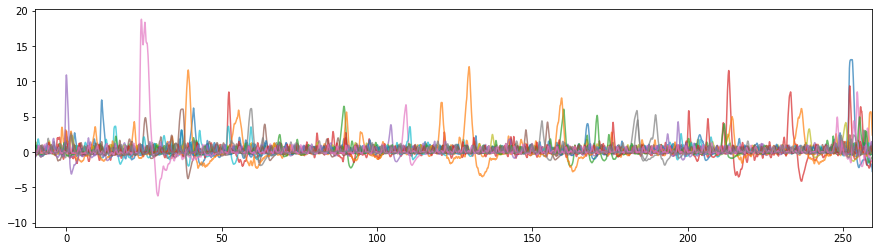

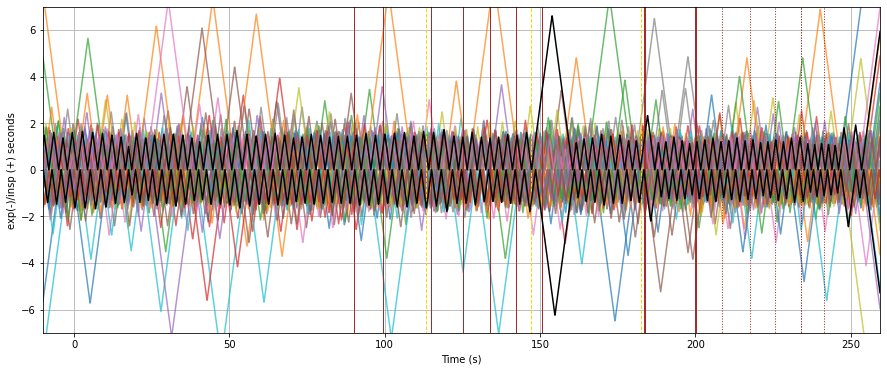

In [48]:
# ax = df_feats['IminT'].plot(figsize=[15,4],color='c',label='Time from Inspiration onsets')
df_alts.plot(figsize=[15,4],legend=False,alpha = 0.7)
plt.xlim([s_time,e_time])
plt.show()

ax = df_IminT.plot(figsize=[15,6],legend=False,alpha = 0.7)
(-df_EminT).plot(ax=ax,legend=False,alpha = 0.7)

yrange = [-10,10]
tcue_list = [8,13,18]
lowpart_downbeatACCphrase = [6,7,9,10,11,12,14]
entry_melody = [19,21] 
norest_list = [22,23,26,25,26,28]

# just for legend
ax.plot([-20, -20],yrange,linestyle = '--',linewidth=1,color='gold',label = "Trumpet cue")
ax.plot([-20, -20],yrange,linestyle = '-',linewidth=1,color='brown',label = "Low acc. phrase onset") 
ax.plot([-20, -20],yrange,linestyle = '-',linewidth=2,color='brown',label = "Bass theme onset") 
ax.plot([-20, -20],yrange,linestyle = ':',linewidth=1,color='brown',label = "Bass phrase onset no rest") 

for tcue in annotations.loc[tcue_list,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = '--',linewidth=1,color='gold',)   
for tcue in annotations.loc[lowpart_downbeatACCphrase ,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = '-',linewidth=1,color='brown')
for tcue in annotations.loc[entry_melody,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = '-',linewidth=2,color='brown')
for tcue in annotations.loc[norest_list,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = ':',linewidth=1,color='brown')
    
df_feats['IminT'].plot(ax=ax,color='k')
(-df_feats['EminT']).plot(ax=ax,color='k')


ax.set(xlim=[s_time,e_time],ylim=[-7,7],xlabel='Time (s)',ylabel='exp(-)/insp (+) seconds') 
ax.grid()
plt.show()


AU820


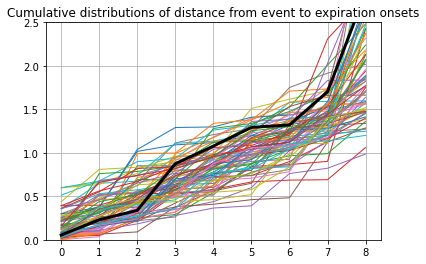

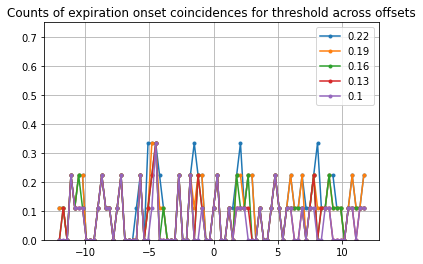

In [58]:
# A random alternative respiration sequence, is it close to these entries? 

threshrange = np.round(np.arange(0.1,0.24,0.03),2)
print(partID)
# sample 
f = interpolate.interp1d(df_feats.index, df_EminT[partID],fill_value='extrapolate')

# sample distrubution of expiration onsets within threshold to event list when assess at different offsets

prox = pd.DataFrame(index = np.arange(-12,12,0.3),columns=threshrange[::-1])
for delta in prox.index:
    C = f(annotations.loc[entry_list,'TIME']+delta)
    C = pd.Series(C).sort_values().reset_index(drop=True)
    C.plot(linewidth=1)
    for thresh in threshrange:
        prox.loc[delta,thresh]=(C<thresh).sum()/len(C)
C = f(annotations.loc[entry_list,'TIME'])
C = pd.Series(C).sort_values().reset_index(drop=True)
C.plot(c='k',linewidth=3,label='Original')
plt.ylim([0,2.5])
plt.grid()
plt.title('Cumulative distributions of distance from event to expiration onsets')
plt.show()

prox.plot(kind='line',marker='.')
plt.title('Counts of expiration onset coincidences for threshold across offsets')
plt.ylim([0,0.75])
plt.grid()
plt.show()

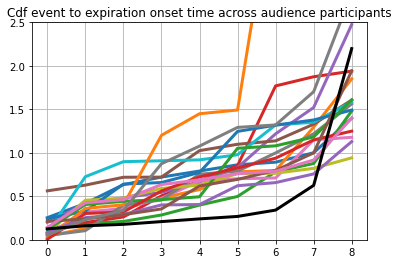

In [54]:
# not sure exactly how close expirations need to be to thsee moments to count as "aligned", so document a range
threshrange = np.round(np.arange(0.1,0.24,0.03),2)

for partID in df_alts.columns:
    f = interpolate.interp1d(df_feats.index, df_EminT[partID],fill_value='extrapolate')
    # sample distribution of expiration onsets within threshold to event list when assess at different offsets
    C = f(annotations.loc[entry_list,'TIME'])
    C = pd.Series(C).sort_values().reset_index(drop=True)
    C.plot(linewidth=3,label=partID)

f = interpolate.interp1d(df_feats.index, df_feats['EminT'],fill_value='extrapolate')
C = f(annotations.loc[entry_list,'TIME'])
C = pd.Series(C).sort_values().reset_index(drop=True)
C.plot(c='k',linewidth=3,label='Original')
plt.ylim([0,2.5])
plt.grid()
plt.title('Cdf event to expiration onset time across audience participants')
plt.show()


The other audience members did not tend to expire as close to these bass entries as this particular participant. 